In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
fake_images_path = r"C:\Downloads\drive-download-20250105T214651Z-001\Fproccessed"
real_images_path = r"C:\Downloads\drive-download-20250105T214651Z-001\Rprocessed"

# Define output directories
output_directory = r"C:\Downloads\ProcessedImages"
train_dir = os.path.join(output_directory, "Train")
test_dir = os.path.join(output_directory, "Test")
val_dir = os.path.join(output_directory, "Validation")

# Create output directories if they don't exist
for folder in [train_dir, test_dir, val_dir]:
    os.makedirs(os.path.join(folder, "Fake"), exist_ok=True)
    os.makedirs(os.path.join(folder, "Real"), exist_ok=True)

def split_and_copy_images(source_path, label, train_dest, test_dest, val_dest, test_size=0.2, val_size=0.1):
    """
    Split images into train, test, and validation sets and copy to respective directories.
    """
    if not os.path.exists(source_path):
        print(f"Source path does not exist: {source_path}")
        return

    files = [f for f in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, f))]
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_size / (1 - test_size), random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(train_dest, label))
    for file in test_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(test_dest, label))
    for file in val_files:
        shutil.copy(os.path.join(source_path, file), os.path.join(val_dest, label))

    print(f"{label} Images Split: {len(train_files)} train, {len(test_files)} test, {len(val_files)} validation")

# Split and copy fake images
split_and_copy_images(
    fake_images_path, "Fake",
    train_dest=train_dir, test_dest=test_dir, val_dest=val_dir
)

# Split and copy real images
split_and_copy_images(
    real_images_path, "Real",
    train_dest=train_dir, test_dest=test_dir, val_dest=val_dir
)

print("Image splitting and copying complete!")


Fake Images Split: 420 train, 120 test, 60 validation
Real Images Split: 430 train, 124 test, 62 validation
Image splitting and copying complete!


In [20]:
# Load ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Add custom layers for your classification task
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replace Flatten with GAP for better generalization
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
train_dir = r"C:\Downloads\ProcessedImages\Train"
val_dir = r"C:\Downloads\ProcessedImages\Validation"
test_dir = r"C:\Downloads\ProcessedImages\Test"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_dir = r"C:\Downloads\ProcessedImages\Train"
val_dir = r"C:\Downloads\ProcessedImages\Validation"
test_dir = r"C:\Downloads\ProcessedImages\Test"

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generate datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 850 images belonging to 2 classes.
Found 122 images belonging to 2 classes.
Found 244 images belonging to 2 classes.


In [23]:
# Unfreeze the last few layers
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all layers except the last 10
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Can use 'val_accuracy' as well
    patience=5,  # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore the model with the best weights
    verbose=1  # Print messages when early stopping is triggered
)
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.6269 - loss: 0.7052 - val_accuracy: 0.4918 - val_loss: 5.7160
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7023 - loss: 0.5677 - val_accuracy: 0.4918 - val_loss: 6.9985
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7000 - loss: 0.5716 - val_accuracy: 0.4918 - val_loss: 2.3487
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7020 - loss: 0.5431 - val_accuracy: 0.4918 - val_loss: 4.0223
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7063 - loss: 0.5713 - val_accuracy: 0.5246 - val_loss: 1.4821


In [25]:
# Save the trained and fine-tuned model to a file
model.save('deepfake_detection_model.h5')


In [26]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


final_train_acc = history.history['accuracy'][-1]  # Get the accuracy from the last epoch
print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6125 - loss: 1.2658
Test Accuracy: 59.84%
Final Training Accuracy: 67.06%


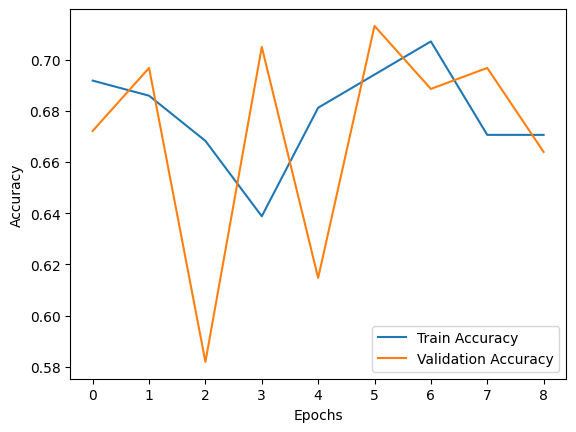

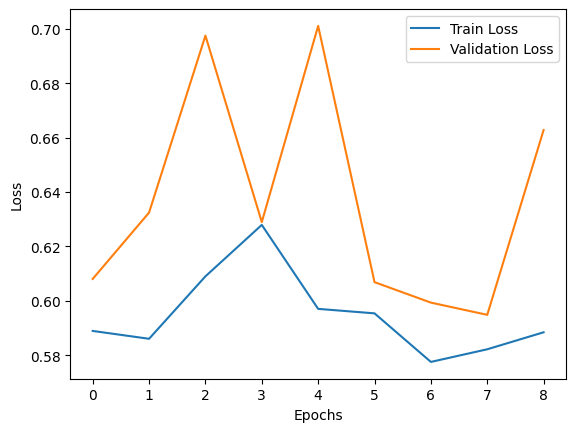

In [27]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
